In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from arviz import hdi
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Model Diagnostics

In [2]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4', 'pgng_m5']
sessions = ['s1', 's2', 's3', 's4']

### 1.1 Stan diagnostics


In [3]:
## Main loop.
diagnostics = []
for m in models:
    
    for s in sessions:

        ## Load Stan summary.
        samples = read_csv(os.path.join('stan_results', s, f'{m}.tsv.gz'), sep='\t', compression='gzip')
        summary = read_csv(os.path.join('stan_results', s, f'{m}_summary.tsv'), sep='\t', index_col=0)
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Apply restrictions.
        summary = summary.T.filter(regex='theta|sigma').T    # Only untransformed parameters.
        ppc = ppc[~np.isinf(ppc.k_u)]                        # Removed fixed parameters.

        ## Identify number of divergences.
        divergence = samples.divergent__.sum()

        ## Identify parameters failing to reach convergence.
        rhat = len(summary.query('R_hat > 1.01'))

        ## Identify parameters with low effective sample size.
        n_eff = len(summary.query('N_Eff < 400'))

        ## Identify number of effective parameters.
        p_loo = ppc.pwaic.sum()

        ## Identify number of poorly predicted observations.
        pk = np.sum(ppc.k_u > 0.7)

        ## Convert to dictionary. Append.
        diagnostics.append(dict(
            model = m,
            session = s,
            divergence = divergence,
            rhat = rhat,
            n_eff = n_eff,
            p_loo = np.round(p_loo, 1),
            pk = np.round(pk, 3)
        ))

## Convert to DataFrame.
diagnostics = DataFrame(diagnostics).sort_values(['session','model']).set_index(['session','model'])
diagnostics

divergence  rhat  n_eff   p_loo    pk
session model                                         
s1      pgng_m1         0.0     2      2    21.3   171
        pgng_m2         0.0     1      1    31.7    44
        pgng_m3         0.0     0      1    40.2    28
        pgng_m4         0.0     0      0    42.6    94
        pgng_m5         0.0     0      0    40.0    22
s2      pgng_m1         0.0     0      0     8.9  1240
        pgng_m2         0.0     0      0    20.1  1161
        pgng_m3         0.0     0      0    25.8  1152
        pgng_m4         0.0     0      4    27.9  2101
        pgng_m5         0.0     0      0    25.9   281
s3      pgng_m1         0.0     0      0     6.5  2873
        pgng_m2         0.0     0      0    15.7  2675
        pgng_m3         0.0     0      0    20.9  2932
        pgng_m4         0.0     0      0    23.4  3487
        pgng_m5         0.0   396    408  1071.4    30
s4      pgng_m1         0.0     0      0     7.4  2669
        pgng_m2         0.0     0      0    16.5  3190
        pgng_m3         0.0     0      0    22.6  3559
        pgng_m4         0.0     0      0    25.0  4521
        pgng_m5         1.0   385    388  1134.8     0

## Section 2: Model Comparison

In [4]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4']
sessions = ['s1', 's2', 's3','s4']

### 2.1 LOO-CV indices

In [5]:
## Main loop.
loocv = []
for m in models:

    for s in sessions:
    
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute LOO-CV.
        loo = -2 * ppc.loo.sum()

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, loocv=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'session', 'model')
loocv.round(1)

model,pgng_m1,pgng_m2,pgng_m3,pgng_m4
session,,,,
s1,-39189.9,-39971.1,-40362.5,-40500.7
s2,-39817.9,-40108.3,-40448.6,-40504.6
s3,-39390.3,-39637.3,-39732.5,-39773.8
s4,-38332.8,-38678.1,-39036.1,-39052.1


### 2.2 Model comparisons

In [6]:
from itertools import combinations

loocv = []
for s in sessions:

    for a, b in list(combinations(models, 2)):

        ## Load data.
        ppc1 = read_csv(os.path.join('stan_results', s, f'{a}_ppc.csv'))
        ppc2 = read_csv(os.path.join('stan_results', s, f'{b}_ppc.csv'))

        arr = -2 * (ppc2.loo - ppc1.loo)

        ## Compute stats.
        N = len(ppc1)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(N)

        ## Convert to dictionary. Append.
        loocv.append(dict(model=m, session=s, a=a, b=b, loocv='%0.1f (%0.1f)' %(mu, se)))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).pivot_table('loocv', 'a', ['session','b'], aggfunc=lambda x: x).fillna('-')
loocv

session             s1                                             s2  \
b              pgng_m2         pgng_m3         pgng_m4        pgng_m2   
a                                                                       
pgng_m1  -781.2 (28.0)  -1172.6 (34.3)  -1310.9 (37.2)  -290.4 (18.8)   
pgng_m2              -   -391.4 (21.1)   -529.6 (25.2)              -   
pgng_m3              -               -   -138.3 (14.5)              -   

session                                           s3                 \
b              pgng_m3        pgng_m4        pgng_m2        pgng_m3   
a                                                                     
pgng_m1  -630.6 (26.3)  -686.6 (27.8)  -247.0 (17.5)  -342.2 (20.7)   
pgng_m2  -340.2 (17.9)  -396.2 (20.4)              -   -95.1 (10.9)   
pgng_m3              -   -56.0 (10.5)              -              -   

session                            s4                                
b              pgng_m4        pgng_m2        pgng_m3        pgng_m4  
a                                                                    
pgng_m1  -383.4 (21.9)  -345.4 (19.4)  -703.4 (26.6)  -719.4 (27.2)  
pgng_m2  -136.4 (13.4)              -  -358.0 (17.8)  -374.0 (18.8)  
pgng_m3    -41.3 (7.8)              -              -    -16.0 (6.1)

## Section 3: Posterior Predictive Checks

In [7]:
## Define parameters.
models = ['pgng_m1', 'pgng_m2', 'pgng_m3', 'pgng_m4']
sessions = ['s1', 's2', 's3', 's4']

### 3.1 Group-level

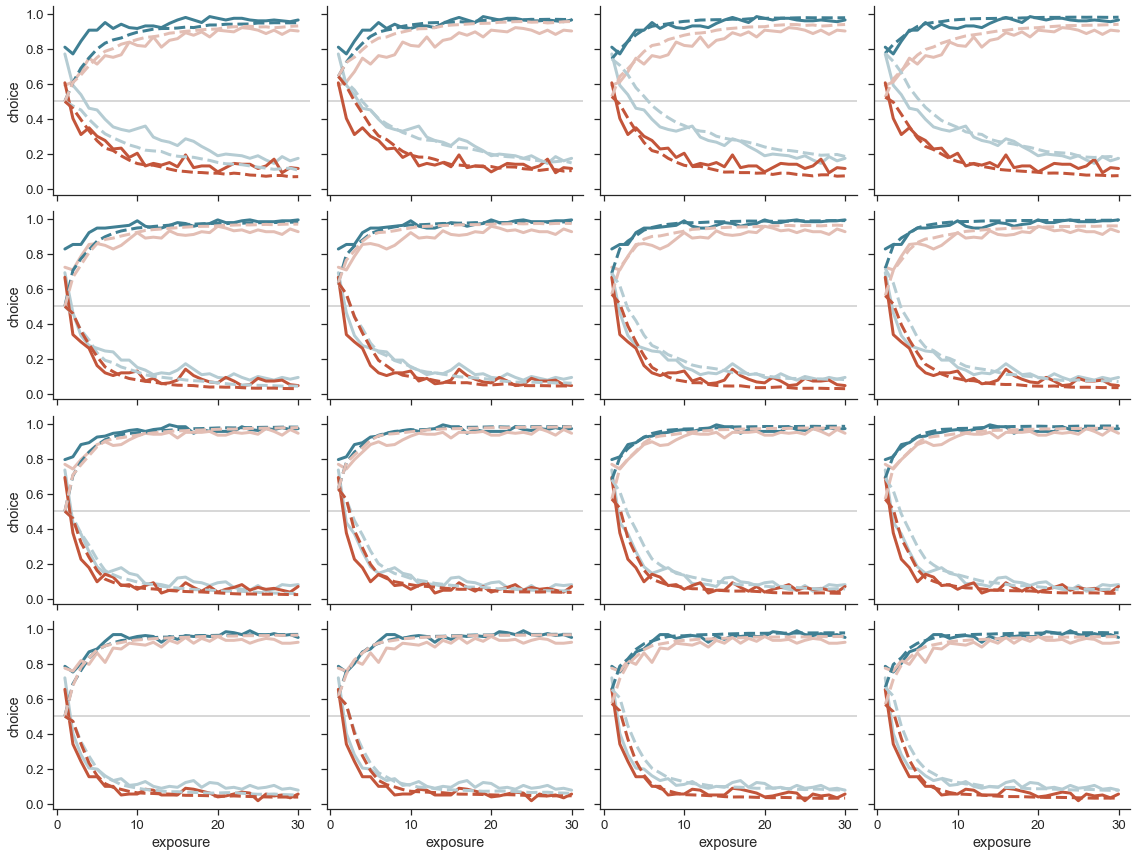

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*4, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Plot learning curves.
        sns.lineplot(x='exposure', y='choice', hue='robot', data=ppc, hue_order=order,
                      palette=palette, lw=3, ci=None, ax=axes[i,j])
        sns.lineplot(x='exposure', y='Y_hat', hue='robot', data=ppc, hue_order=order, 
                      palette=palette, lw=3, ci=None, linestyle='--', ax=axes[i,j])

        ## Add trend line.
        axes[i,j].axhline(0.5, color='0.5', alpha=0.4, zorder=-10)
        
        ## Adjust legend.
        axes[i,j].legend_.set_visible(False)
        
sns.despine()
plt.tight_layout()

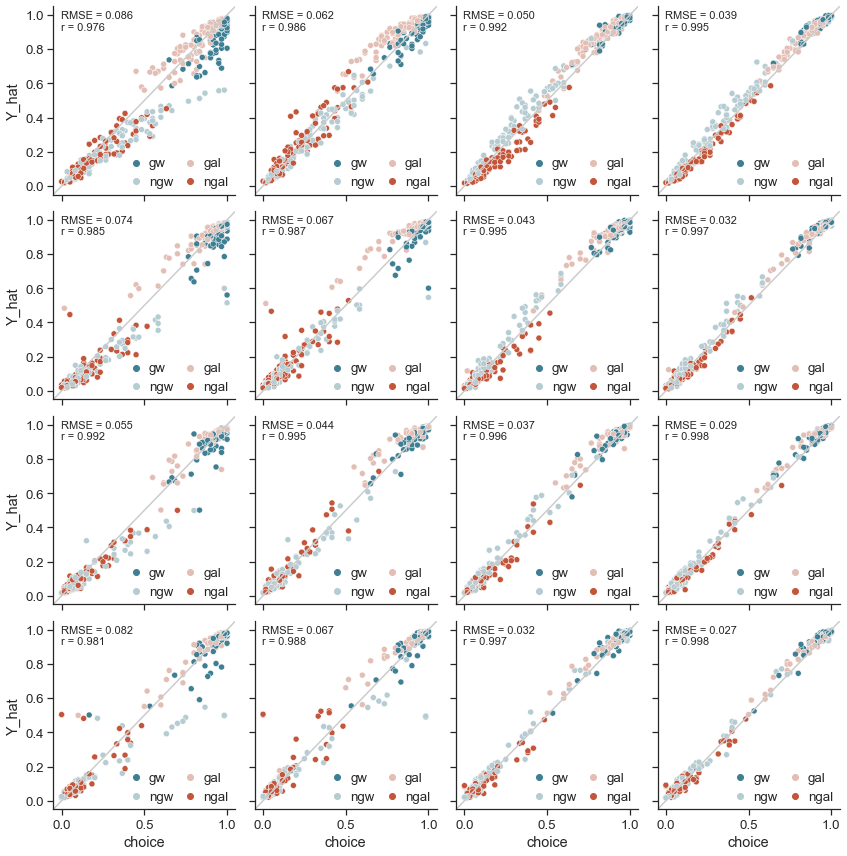

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(len(sessions), len(models), figsize=(len(models)*3, len(sessions)*3),
                         sharex=True, sharey=True)

## Define aesthetics.
order = ['gw', 'ngw', 'gal', 'ngal']
palette = sns.diverging_palette(220, 20, n=4)

## Define convenience functions.
RMSE = lambda x: np.sqrt(np.mean(np.square(x)))

for i, s in enumerate(sessions):
    
    for j, m in enumerate(models):
        
        ## Load posterior predictive check.
        ppc = read_csv(os.path.join('stan_results', s, f'{m}_ppc.csv'))

        ## Compute accuracy by participant / condition.
        gb = ppc.groupby(['subject','robot']).agg({'choice':'mean', 'Y_hat':'mean'}).reset_index()
        
        ## Compute fit statistics.
        rmse = RMSE(gb.choice - gb.Y_hat)
        corr = gb[['choice','Y_hat']].corr().values[0,1]
        
        ## Plot learning curves.
        sns.scatterplot(x='choice', y='Y_hat', hue='robot', data=gb, hue_order=order, 
                        palette=palette, ax=axes[i,j])
        axes[i,j].plot([-1,2], [-1,2], color='0.8')
        
        ## Adjust x-axis.
        axes[i,j].set(xlim=(-0.05,1.05))
        
        ## Adjust y-axis
        axes[i,j].set(ylim=(-0.05,1.05))
        
        ## Adjust legend.
        axes[i,j].legend(loc=4, frameon=False, ncol=2, borderpad=0, handletextpad=0, columnspacing=0.3)
        
        ## Add annotation.
        annot = 'RMSE = %0.3f\nr = %0.3f' %(rmse, corr)
        axes[i,j].annotate(annot, (0,0), (0.04, 0.98), 'axes fraction', ha='left', va='top', fontsize=11)
        
sns.despine()
plt.tight_layout()

## Section 4: Group-level parameters

In [10]:
## Define parameters.
model = 'pgng_m4'
sessions = ['s1', 's2', 's3', 's4']
cols = ['Mean','StdDev','2.5%','50%','97.5%']

## Iteratively load Stan summaries.
summary = concat([
    read_csv(os.path.join('stan_results', s, f'{model}_summary.tsv'), sep='\t', index_col=0) 
    for s in sessions
])

## Restrict to group-level parameters.
summary = summary.T.filter(regex='theta_mu').T[cols]

### 4.1 Inverse temperature

In [11]:
summary.T.filter(regex='theta_mu\[1').T * 10

,Mean,StdDev,2.5%,50%,97.5%
name,,,,,
theta_mu[1],10.2,0.752,8.7,10.2,11.7
theta_mu[1],17.3,1.260,14.8,17.2,19.8
theta_mu[1],20.0,1.560,17.1,19.9,23.1
theta_mu[1],21.1,1.750,17.7,21.0,24.6


### 4.2 Go bias

In [12]:
summary.T.filter(regex='theta_mu\[2').T * 5

,Mean,StdDev,2.5%,50%,97.5%
name,,,,,
theta_mu[2],0.1045,0.0490,0.003495,0.1035,0.1960
theta_mu[2],0.2590,0.0715,0.113000,0.2590,0.3940
theta_mu[2],0.2920,0.0640,0.165500,0.2905,0.4145
theta_mu[2],0.2860,0.0930,0.095000,0.2860,0.4610


### 4.3 Pavlovian bias

In [13]:
summary.T.filter(regex='theta_mu\[3').T * 5

,Mean,StdDev,2.5%,50%,97.5%
name,,,,,
theta_mu[3],1.345,0.1010,1.1350,1.345,1.535
theta_mu[3],0.835,0.1195,0.5900,0.840,1.060
theta_mu[3],0.605,0.1005,0.4000,0.610,0.795
theta_mu[3],0.540,0.1305,0.2655,0.540,0.785


### 4.4 Learning rate (positive)

In [14]:
summary.T.filter(regex='theta_mu\[4').T

,Mean,StdDev,2.5%,50%,97.5%
name,,,,,
theta_mu[4],-0.903,0.0660,-1.04,-0.903,-0.777
theta_mu[4],-1.060,0.0532,-1.17,-1.060,-0.961
theta_mu[4],-1.130,0.0517,-1.23,-1.130,-1.030
theta_mu[4],-1.090,0.0573,-1.21,-1.090,-0.982


### 4.5 Negative rate (positive)

In [15]:
summary.T.filter(regex='theta_mu\[5').T

,Mean,StdDev,2.5%,50%,97.5%
name,,,,,
theta_mu[5],-1.28,0.0596,-1.40,-1.28,-1.17
theta_mu[5],-1.30,0.0551,-1.41,-1.30,-1.19
theta_mu[5],-1.17,0.0520,-1.28,-1.17,-1.08
theta_mu[5],-1.26,0.0459,-1.35,-1.26,-1.17


## Section 5: Parameter stability

## Section 6: Reliability

### 6.1 Split-half reliability

In [21]:
## Define parameters.
sessions = ['s1', 's2', 's3', 's4']
params = ['b1', 'b2', 'b3', 'a1', 'a2']

## Main loop.
reliability = []
for session in sessions:
    
    ## Load Stan summary.
    summary = read_csv(os.path.join('stan_results', session, 'pgng_m4_sh_summary.tsv'), 
                                    sep='\t', index_col=0)

    ## Iterate over parameters.
    for param in params:
        
        ## Extract parameter.
        arr = summary.T.filter(regex=param).T['Mean'].values.reshape(2,-1)
        
        ## Compute reliability.
        r = np.corrcoef(arr)[0,1]
        
        ## Append info.
        reliability.append(dict(session=session, param=param, r=r))
        
## Convert to DataFrame.
reliability = DataFrame(reliability).pivot_table('r', 'param', 'session')
reliability.round(3)

session,s1,s2,s3,s4
param,,,,
a1,0.657,0.993,0.376,0.556
a2,0.184,0.528,0.957,0.187
b1,0.827,0.871,0.946,0.988
b2,0.396,0.987,0.989,0.943
b3,0.382,0.815,0.850,0.942
